# HW-5: Reactions, Chemical Kinectics, Non-Linear Least-Squares and Convolution Neural Networks 

## What is our goal? 

The goal of this project is to estimate reaction parameters from simulated species concentration data. We will consider the Langmuir-Hinshelwood reaction mechanism for a single reactans as a vehicle. In case succesful, we can consider other reactions such as the Brusselator model from HW-2, an auto-catalytic reaction or a combustor with synthetic fuel or otherwise. 

The forward model consists of assuming the chemical reaction parameters to be known (tabulated, given). With this data, the evolution of the chemical species as a function of time can be computed. 

The inverse (backward) model consists of recovering the chemical reaction parameters from two components: the first is the forward model and the second is the measured data. The reaction parameters can be recovered by solving a non-linear least squares problem in which the mismatch (discrepancy) between measured and simulated values is minimized.

Our goal here is to solve the non-linear least-squares problem using a convolutional neural network (among other approaches). 

The example [blog page on the use of fluxdiffeq](https://julialang.org/blog/2019/01/fluxdiffeq/) will be used as a demonstration of what is currently possible (despite it being develop in Julia). 

We will require functionality that allows to compute the sensitivity of the solution of the ODE system (typically mass fraction) wrt changes in the parameters (typically reaction kinectics). Such functionality is available e.g. in Cantera, as shown in this example [sensivity computation in Cantera](https://cantera.org/examples/python/reactors/sensitivity1.py.html). Domenico wonders whether similar is available elsewhere.  

We intend to go through the following steps: 

1. Introduction: we intend to solve to non-linear least-squares problems and to estimate reaction parameters by minimizing the mismatch between between simulated and measured concentration data; 

2. Forward Problem Formulation: describe forward model Eqn. (17) in Alvirez-Raminez-2016; set-up forward model possibly using chempy; solve the forward model using scipy.integrate.solve_ivp() and compare solution with Fig. 1 ($\Sigma_T=6.0$) and Fig. 2 ($\Sigma_T=15.0$) in Alvirez-Raminez-2016; 

3. Inverse Problem Formulation: formulate cost functional as Eqn. (43) in Alvirez-Raminez-2016 (sum of various time samples of single concentration profile); 

4. Sensitivity of concentration profiles wrt. reaction parameters: use numerical and automatic differentiation to compute sensitivity of concentration profiles wrt. reaction parameters. For an example using autograd (old?), see [Sensitivity analysis with odeint and autograd at Carnegie Mellon](https://kitchingroup.cheme.cmu.edu/blog/2019/09/13/Sensitivity-analysis-with-odeint-and-autograd/). For an example using JAX (new, requires JIT), see [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) and [this example](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). 

5. Cost function and gradient: sample and plot cost functional and its gradient wrt. the design parameters;  

6. Solve Inverse Problem using Derivative-Free Optimization methods with and without noice added to the measurements;  

7. Solve Inverse Problem using Derivative-Based Optimization methods with and without noice added to the measurements; compare cost of computation (number of cost function evaluations); 

8. Conclusions; 

## Import Libraries

In [1]:
import numpy as np
print("Succesfully imported %s -- Version: %s"%(np.__name__,np.__version__))
import scipy
print("Succesfully imported %s -- Version: %s"%(scipy.__name__,scipy.__version__))
import matplotlib.pyplot as plt
print("Succesfully imported %s"%plt.__name__)
import pandas as pd
print("Succesfully imported %s -- Version: %s"%(pd.__name__,pd.__version__))
import sympy as sym 
print("Succesfully imported %s -- Version: %s"%(sym.__name__,sym.__version__))
from scipy import optimize
print("Succesfully imported %s"%optimize.__name__)
from scipy.optimize import fsolve
print("Succesfully imported %s"%fsolve.__name__)
from scipy.signal import find_peaks
print("Succesfully imported %s"%find_peaks.__name__)
from scipy.linalg import orth
print("Succesfully imported %s"%orth.__name__)
from scipy.integrate import odeint
print("Succesfully imported %s"%odeint.__name__)

Succesfully imported numpy -- Version: 1.20.1
Succesfully imported scipy -- Version: 1.6.2
Succesfully imported matplotlib.pyplot
Succesfully imported pandas -- Version: 1.2.4
Succesfully imported sympy -- Version: 1.8
Succesfully imported scipy.optimize
Succesfully imported fsolve
Succesfully imported find_peaks
Succesfully imported orth
Succesfully imported odeint


## Section 1/: Introduction and Model Description

Describe problem, solution approach and references to examples. 

 ## Section 2:/ Forward Model: Time-Integration of a System of Coupled ODEs

Describe forward-time integration for the mass fraction of the species. (Does Python provide functionality to represent model parameters?)

### Section 2.1/: Example of solving an ODE (to be adapted to more suitable and extended with sensitivity)

The example that follows was taken from the [numpy manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). 

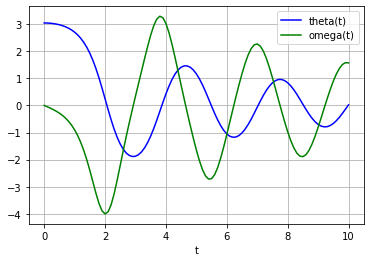

In [2]:
#..set rhs-function of ODE system 
>>> def pend(y, t, b, c):
...     theta, omega = y
...     dydt = [omega, -b*omega - c*np.sin(theta)]
...     return dydt

#..set parameter values 
b=.25; c= 5.0;

#..set initial conditions 
y0 = [np.pi - 0.1, 0.0];

#..set time interval 
t = np.linspace(0, 10, 101);

#..solve ODE systemk 
sol = odeint(pend, y0, t, args=(b, c), full_output=1, printmessg=0);

#..plot solution obtained 
plt.plot(t, sol[0][:, 0], 'b', label='theta(t)')
plt.plot(t, sol[0][:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

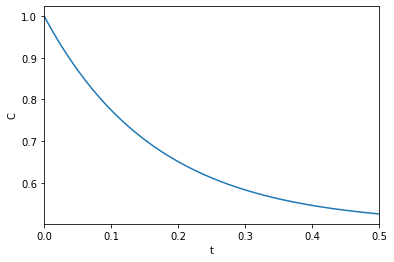

In [2]:
import autograd.numpy as np
from autograd.scipy.integrate import odeint
from autograd import jacobian
from autograd.builtins import tuple

import matplotlib.pyplot as plt

Ca0 = 1.0
k1 = k_1 = 3.0

tspan = np.linspace(0, 0.5)

def C(K):
    k1, k_1 = K
    def dCdt(Ca, t, k1, k_1):
        return -k1 * Ca + k_1 * (Ca0 - Ca)
    sol = odeint(dCdt, Ca0, tspan, tuple((k1, k_1)))
    return sol

plt.plot(tspan, C([k1, k_1]))
plt.xlim([tspan.min(), tspan.max()])
plt.xlabel('t')
plt.ylabel('C');

## Section 2.2/: Loop over the forward model 

In [ ]:
bnominal = .25 
bmin = bnominal/2; bmax = 2*bnominal; 
N = 100; bstep = (bmax-bmin)/N
bvec = np.linspace(bmin, bmax, num=N+1)
costfvec = np.linspace(N+1) 
for i in range(N): 
    sol = odeint(pend, y0, t, args=(bvec[iS], c), full_output=1, printmessg=0);
    mismatch = sol[0][:,0] - target
    costfvec[i] = sp.norm(mismatch)
    
# plot the cost functional  

## Section 3/: Forward Model: Sensitivity of Solution wrt Model Parameters 

Describe how to compute sensitivity in the forward model with respect to changes in the model parameters (chemical reaction kinectics). Can sensitivity of mass fraction wrt the model parameters be computed? For an example, see [Sensitivity analysis with odeint and autograd at Carnegie Mellon](https://kitchingroup.cheme.cmu.edu/blog/2019/09/13/Sensitivity-analysis-with-odeint-and-autograd/)

## Section 4/: Inverse Model Formulation and Sensivity 

Describe least-squares fit between model and measured data. The data can be output of the forward model perturbed eventually by noice. Describe gradient of least-squares functional wrt model parameters. Use upper and lower bounds on the design variables as the easier way to regularize the problem. 

## Section 5/: Inverse Model Solve using Classical Derivatived-Based Methods

Use non-linear optimization methods discussed in ANM-2021 en implemented in scipy. More information goes here. 

In [7]:
def model(x, u):
...     return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])

def fun(x, u, y):
...     return model(x, u) - y

def jac(x, u, y):
...     J = np.empty((u.size, x.size))
...     den = u ** 2 + x[2] * u + x[3]
...     num = u ** 2 + x[1] * u
...     J[:, 0] = num / den
...     J[:, 1] = x[0] * u / den
...     J[:, 2] = -x[0] * num * u / den ** 2
...     J[:, 3] = -x[0] * num / den ** 2
...     return J

In [9]:
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
...               8.33e-2, 7.14e-2, 6.25e-2])
>>> y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
...               4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
>>> x0 = np.array([2.5, 3.9, 4.15, 3.9])
>>> res = scipy.optimize.least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)
# may vary

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


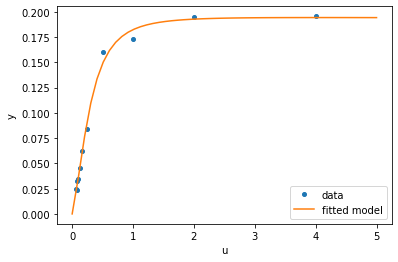

In [10]:
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data') 
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

## Section 6/:  Inverse Model Solve using Convolutional Neural Networks 

Training of network. Use network to solve non-linear least-squares problem. 

## References  

1. [wiki on autocatalysis](https://en.wikipedia.org/wiki/Autocatalysis) 
2. [wiki on non-linear least-squares](https://en.wikipedia.org/wiki/Non-linear_least_squares)
3. [wiki on Levenberg-Marquard algorithm](https://en.wikipedia.org/wiki/Levenbergâ€“Marquardt_algorithm)  
4. [Cantera for chemical reactiions](https://cantera.org) 
5. [blog page on the use of fluxdiffeq](https://julialang.org/blog/2019/01/fluxdiffeq/)
6. [Example of a non-linear least squares problem ready to roll](https://julialang.org/blog/2019/01/fluxdiffeq/) Non-Linear least-squares problem using a neural network problem.